Copyright 2020 The Google Research Authors. All Rights Reserved.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**NOTE: Executing the code (training or evaluation) for the first time will download the full CLEVR dataset (17.7GB).**

In [463]:
# Requirements: Python 3.x, TensorFlow 2.x, TensorFlow Datasets

from absl import logging
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# When executing this notebook out of a subfolder, use the command below to
# change to the project's root folder (required for imports):
# %cd ..

import slot_attention.data as data_utils
import slot_attention.model as model_utils

In [464]:
# Hyperparameters.
seed = 0
batch_size = 1
num_slots = 2
num_iterations = 3
resolution = (520, 704)
ckpt_path = "tmp/object_discovery"  # Path to model checkpoint.

In [465]:
def load_model(checkpoint_dir, num_slots=11, num_iters=3, batch_size=16):
  resolution = (520, 704)
  model = model_utils.build_model(
      resolution, batch_size, num_slots, num_iters,
      model_type="object_discovery")

  ckpt = tf.train.Checkpoint(network=model)
  ckpt_manager = tf.train.CheckpointManager(
      ckpt, directory=checkpoint_dir, max_to_keep=5)

  if ckpt_manager.latest_checkpoint:
    status = ckpt.restore(ckpt_manager.latest_checkpoint)
    status.expect_partial()
    print(f"Restored from {ckpt_manager.latest_checkpoint}")
    logging.info("Restored from %s", ckpt_manager.latest_checkpoint)

  print(num_slots)
  return model

In [466]:
# Build dataset iterators, optimizers and model.
tf.random.set_seed(seed)
data_iterator = data_utils.build_clevr_iterator(
    batch_size = 5, split="validation", resolution=resolution, shuffle=True,
    max_n_objects=6, get_properties=False, apply_crop=True)

model = load_model(ckpt_path, num_slots=num_slots, num_iters=num_iterations,
                   batch_size=batch_size)

Restored from tmp/object_discovery/ckpt-500
2


In [467]:
next(data_iterator)

{'image': <tf.Tensor: shape=(5, 520, 704, 3), dtype=float32, numpy=
 array([[[[-1.76470578e-01, -1.76470578e-01, -1.76470578e-01],
          [-1.76470578e-01, -1.76470578e-01, -1.76470578e-01],
          [-1.76470578e-01, -1.76470578e-01, -1.77896604e-01],
          ...,
          [-1.68627441e-01, -1.68627441e-01, -1.68627441e-01],
          [-1.68627441e-01, -1.68627441e-01, -1.68627441e-01],
          [-1.68627441e-01, -1.68627441e-01, -1.68627441e-01]],
 
         [[-1.76470578e-01, -1.76470578e-01, -1.76470578e-01],
          [-1.76470578e-01, -1.76470578e-01, -1.76470578e-01],
          [-1.76393792e-01, -1.76393792e-01, -1.77743033e-01],
          ...,
          [-1.68627441e-01, -1.68627441e-01, -1.68627441e-01],
          [-1.68627441e-01, -1.68627441e-01, -1.68627441e-01],
          [-1.68627441e-01, -1.68627441e-01, -1.68627441e-01]],
 
         [[-1.76470578e-01, -1.76470578e-01, -1.76470578e-01],
          [-1.76470578e-01, -1.76470578e-01, -1.76470578e-01],
          [-1.

In [468]:
next(data_iterator)['image']

<tf.Tensor: shape=(5, 520, 704, 3), dtype=float32, numpy=
array([[[[-0.16862744, -0.17647058, -0.17647058],
         [-0.16862744, -0.17647058, -0.17647058],
         [-0.16862744, -0.17647058, -0.17647058],
         ...,
         [-0.16862744, -0.16862744, -0.16862744],
         [-0.16862744, -0.16862744, -0.16862744],
         [-0.16862744, -0.16862744, -0.16862744]],

        [[-0.16904977, -0.17647058, -0.17647058],
         [-0.16904977, -0.17647058, -0.17647058],
         [-0.1688962 , -0.176317  , -0.176317  ],
         ...,
         [-0.16820511, -0.16820511, -0.16862744],
         [-0.16820511, -0.16820511, -0.16862744],
         [-0.16820511, -0.16820511, -0.16862744]],

        [[-0.17194569, -0.17647058, -0.17647058],
         [-0.17194569, -0.17647058, -0.17647058],
         [-0.17073905, -0.17526394, -0.17526394],
         ...,
         [-0.16530919, -0.16530919, -0.16862744],
         [-0.16530919, -0.16530919, -0.16862744],
         [-0.16530919, -0.16530919, -0.1686274

In [469]:
next(data_iterator).keys()

dict_keys(['image'])

In [470]:
def renormalize(x):
  """Renormalize from [-1, 1] to [0, 1]."""
  return x / 2. + 0.5

def get_prediction(model, batch, idx=0):
  recon_combined, recons, masks, slots = model(batch)

  # image = renormalize(batch)[idx]
  recon_combined = renormalize(recon_combined)[idx]  # without [idx]: (1, 7, 128, 128, 3)
  recons = renormalize(recons)[idx]
  masks = masks[idx]
  
  image = batch[idx]
  return image, recon_combined, recons, masks, slots

In [471]:
# Get new batch.
batch = next(data_iterator)
batch_touse = batch["image"]
print(batch_touse.shape)
print(batch_touse[0].shape)

(5, 520, 704, 3)
(520, 704, 3)


In [472]:
batch_touse[0]

<tf.Tensor: shape=(520, 704, 3), dtype=float32, numpy=
array([[[-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.17005347, -0.17005347],
        ...,
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744]],

       [[-0.16904977, -0.16904977, -0.16904977],
        [-0.16904977, -0.16904977, -0.16904977],
        [-0.1688962 , -0.17024544, -0.17032222],
        ...,
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744]],

       [[-0.17194569, -0.17194569, -0.17194569],
        [-0.17194569, -0.17194569, -0.17194569],
        [-0.17073905, -0.17156176, -0.17216508],
        ...,
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744]],

       ...,

     

In [1]:
plt.imshow(batch_touse[0])

NameError: name 'plt' is not defined

In [474]:
# Predict.
image, recon_combined, recons, masks, slots = get_prediction(model, batch_touse)

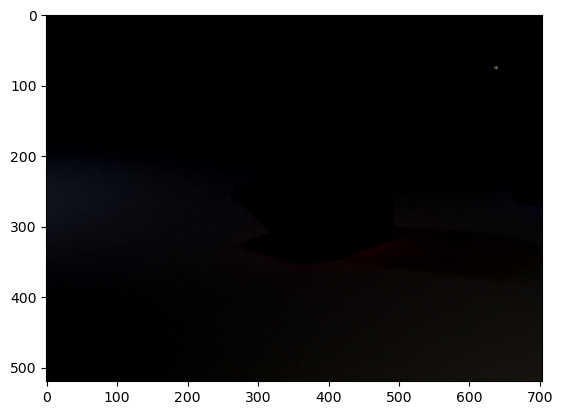

In [475]:
plt.imshow(image)

In [476]:
image

<tf.Tensor: shape=(520, 704, 3), dtype=float32, numpy=
array([[[-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.17005347, -0.17005347],
        ...,
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744]],

       [[-0.16904977, -0.16904977, -0.16904977],
        [-0.16904977, -0.16904977, -0.16904977],
        [-0.1688962 , -0.17024544, -0.17032222],
        ...,
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744]],

       [[-0.17194569, -0.17194569, -0.17194569],
        [-0.17194569, -0.17194569, -0.17194569],
        [-0.17073905, -0.17156176, -0.17216508],
        ...,
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744],
        [-0.16862744, -0.16862744, -0.16862744]],

       ...,

     

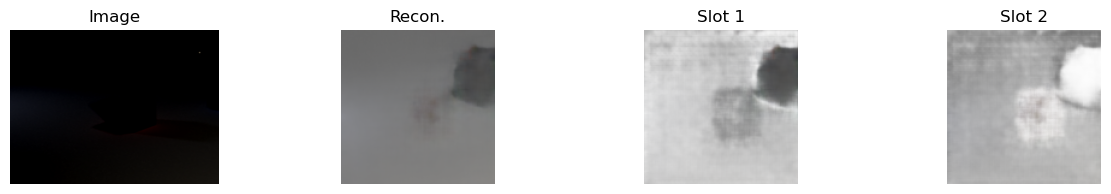

In [477]:
# Visualize.
num_slots = len(masks)
fig, ax = plt.subplots(1, num_slots + 2, figsize=(15, 2))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined)
ax[1].set_title('Recon.')
for i in range(num_slots):
  ax[i + 2].imshow(recons[i] * masks[i] + (1 - masks[i]))
  ax[i + 2].set_title('Slot %s' % str(i + 1))
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')

In [478]:
print(image.shape)
print(recons.shape)

(520, 704, 3)
(2, 128, 128, 3)


In [479]:
import cv2
import os

In [480]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [481]:
np.shape(images)

(1512, 520, 704, 3)

In [482]:
images[0].shape

(520, 704, 3)

In [483]:
new_images = np.copy(images)

In [484]:
for i in range(np.shape(images)[0]):
    images[i] = cv2.resize(images[i], dsize=(128, 128), interpolation=cv2.INTER_CUBIC)

In [485]:
images[0]

array([[[128, 128, 128],
        [131, 131, 131],
        [139, 139, 139],
        ...,
        [131, 131, 131],
        [132, 132, 132],
        [123, 123, 123]],

       [[143, 143, 143],
        [160, 160, 160],
        [131, 131, 131],
        ...,
        [117, 117, 117],
        [116, 116, 116],
        [128, 128, 128]],

       [[127, 127, 127],
        [124, 124, 124],
        [132, 132, 132],
        ...,
        [136, 136, 136],
        [138, 138, 138],
        [143, 143, 143]],

       ...,

       [[134, 134, 134],
        [134, 134, 134],
        [119, 119, 119],
        ...,
        [128, 128, 128],
        [128, 128, 128],
        [127, 127, 127]],

       [[127, 127, 127],
        [143, 143, 143],
        [137, 137, 137],
        ...,
        [130, 130, 130],
        [128, 128, 128],
        [121, 121, 121]],

       [[131, 131, 131],
        [152, 152, 152],
        [125, 125, 125],
        ...,
        [127, 127, 127],
        [128, 128, 128],
        [134, 134, 134]]

In [486]:
print(np.shape(new_images))
print(np.shape(images))

(1512, 520, 704, 3)
(1512, 128, 128, 3)


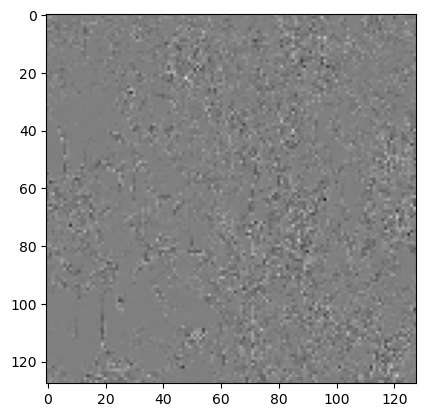

In [487]:
plt.imshow(images[0])

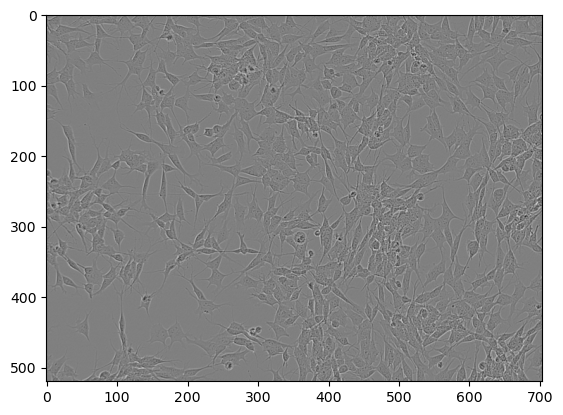

In [488]:
plt.imshow(new_images[0])

In [489]:
test1 = np.expand_dims(new_images[0], axis=0)
test1.shape

(1, 520, 704, 3)

In [490]:
image, recon_combined, recons, masks, slots = get_prediction(model, test1)

In [491]:
image.shape

(520, 704, 3)

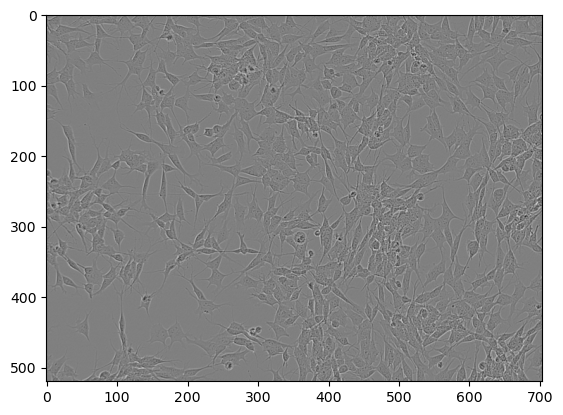

In [492]:
plt.imshow(image)

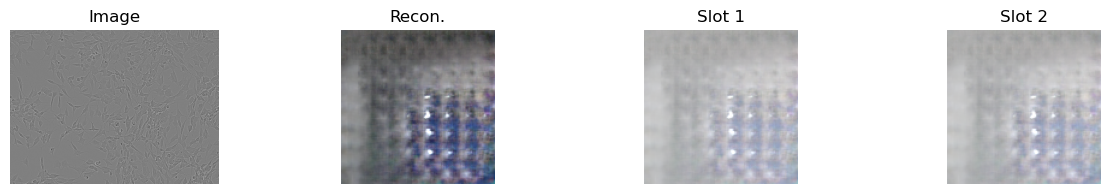

In [493]:
# Visualize.
num_slots = len(masks)
fig, ax = plt.subplots(1, num_slots + 2, figsize=(15, 2))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined)
ax[1].set_title('Recon.')
for i in range(num_slots):
  ax[i + 2].imshow(recons[i] * masks[i] + (1 - masks[i]))
  ax[i + 2].set_title('Slot %s' % str(i + 1))
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')

In [494]:
recons[0]

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.38698888, 0.3865808 , 0.38638663],
        [0.35949546, 0.36523616, 0.37423092],
        [0.35359284, 0.35872576, 0.3685653 ],
        ...,
        [0.34218496, 0.34081846, 0.31211483],
        [0.3391021 , 0.3402065 , 0.32953817],
        [0.3238377 , 0.32015207, 0.3378479 ]],

       [[0.35649505, 0.36032647, 0.3592441 ],
        [0.3402132 , 0.3526413 , 0.3599625 ],
        [0.34776163, 0.364752  , 0.3774517 ],
        ...,
        [0.29245543, 0.29177204, 0.2922966 ],
        [0.28431544, 0.28666744, 0.28238362],
        [0.2651924 , 0.27703997, 0.30987477]],

       [[0.36350417, 0.364937  , 0.36386538],
        [0.34925663, 0.36527896, 0.36614534],
        [0.34752634, 0.36901003, 0.3739757 ],
        ...,
        [0.2628035 , 0.2740757 , 0.25912097],
        [0.26969576, 0.27810606, 0.26313955],
        [0.2461743 , 0.26499328, 0.29743534]],

       ...,

       [[0.43674427, 0.45386797, 0.46523085],
        [0.41

In [495]:
image

array([[[127, 127, 127],
        [129, 129, 129],
        [131, 131, 131],
        ...,
        [132, 132, 132],
        [126, 126, 126],
        [123, 123, 123]],

       [[127, 127, 127],
        [126, 126, 126],
        [127, 127, 127],
        ...,
        [129, 129, 129],
        [125, 125, 125],
        [119, 119, 119]],

       [[132, 132, 132],
        [130, 130, 130],
        [129, 129, 129],
        ...,
        [118, 118, 118],
        [126, 126, 126],
        [130, 130, 130]],

       ...,

       [[131, 131, 131],
        [114, 114, 114],
        [129, 129, 129],
        ...,
        [133, 133, 133],
        [136, 136, 136],
        [136, 136, 136]],

       [[124, 124, 124],
        [109, 109, 109],
        [130, 130, 130],
        ...,
        [134, 134, 134],
        [129, 129, 129],
        [125, 125, 125]],

       [[125, 125, 125],
        [120, 120, 120],
        [131, 131, 131],
        ...,
        [131, 131, 131],
        [128, 128, 128],
        [132, 132, 132]]

In [496]:
images = load_images_from_folder("/Users/justinli/Desktop/slot_attention/images/livecell_train_val_images")
images = load_images_from_folder("/Users/justinli/Desktop/slot_attention/images/livecell_test_images")

In [497]:
data_iterator = images

In [498]:
np.shape(data_iterator)

(1512, 520, 704, 3)

In [499]:
import statistics

In [500]:
data_iterator = data_iterator[0:1500]
np.shape(data_iterator)

(1500, 520, 704, 3)

In [501]:
test1 = data_iterator[10]

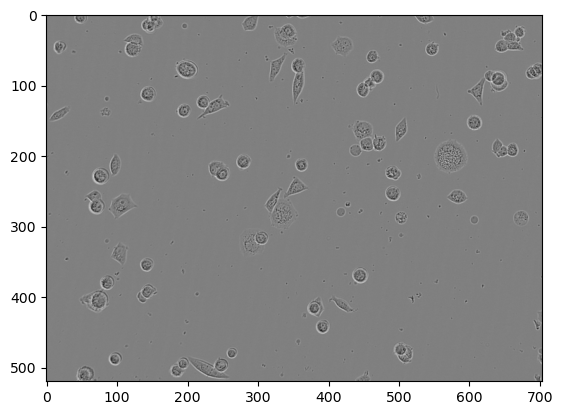

In [502]:
plt.imshow(test1)

In [503]:
test1 = np.squeeze(test1)
test1 = cv2.resize(test1, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
test1 = test1/255
test1 = tf.cast(test1, dtype = tf.float32)
test1 = np.expand_dims(test1, axis=0)

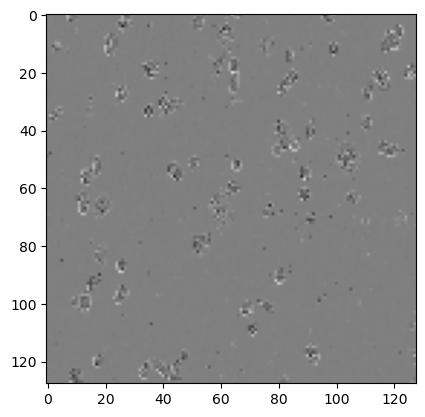

In [504]:
plt.imshow(test1[0])

In [2]:
"""Training loop for object discovery with Slot Attention."""

# We use `tf.function` compilation to speed up execution. For debugging,
# consider commenting out the `@tf.function` decorator.


from turtle import shape


def l2_loss(prediction, target):
    
  print(f'this is the shape of prediction: {prediction.shape}')
  print(f'this is the shape of target: {target.shape}')

  return tf.reduce_mean(tf.math.squared_difference(prediction, target))


@tf.function
def train_step(batch, model, optimizer):
  """Perform a single training step."""

  # Get the prediction of the models and compute the loss.
  with tf.GradientTape() as tape:
    preds = model(batch["image"], training=True)
    recon_combined, recons, masks, slots = preds
    loss_value = l2_loss(batch["image"], recon_combined)
    del recons, masks, slots  # Unused.

  # Get and apply gradients.
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))   

  return loss_value


average_loss = []

def main():
  # Hyperparameters of the model.
  batch_size = 50
  num_slots = 2
  num_iterations = 3 # Number of iterations in Slot Attention
  base_learning_rate = 0.0004
  num_train_steps = 30
  warmup_steps = 5
  decay_rate = 0.5
  decay_steps = 100000
  epoch_size = 10
  tf.random.set_seed(0)
  resolution = (128, 128)

  # Build dataset iterators, optimizers and model.
  '''
  data_iterator = data_utils.build_clevr_iterator(
      batch_size, split="train", resolution=resolution, shuffle=True,
      max_n_objects=6, get_properties=False, apply_crop=True)
  '''
  optimizer = tf.keras.optimizers.Adam(base_learning_rate, epsilon=1e-08)

  model2 = model_utils.build_model(resolution, batch_size, num_slots,
                                  num_iterations, model_type="object_discovery")
  
  model_utils.build_model(resolution, batch_size, num_slots,
                                  num_iterations, model_type="object_discovery")
                                  
  # Prepare checkpoint manager.
  global_step = tf.Variable(
      0, trainable=False, name="global_step", dtype=tf.int64)
  

  for j in range(np.shape(data_iterator)[0]):
    data_iterator[j] = cv2.resize(data_iterator[j], dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    data_iterator[j] = data_iterator[j]/255
    data_iterator[j] = tf.cast(data_iterator[j], dtype = tf.float32)
    
 
  

  for l in range(epoch_size):
    loss = []

    new_index = np.arange(np.shape(data_iterator)[0])
    new_shuffle_index = tf.random.shuffle(new_index)
    new_train_inputs = tf.gather(data_iterator, new_shuffle_index)

    for i in range(num_train_steps):

      start = i * batch_size
      end = (i + 1) * batch_size
      
      batch = new_train_inputs[start:end]

      batch = tf.convert_to_tensor(batch)

      batch = {'image':batch}

      # Learning rate warm-up.
      if global_step < warmup_steps:
        learning_rate = base_learning_rate * tf.cast(global_step, tf.float32) / tf.cast(warmup_steps, tf.float32)
      else:
        learning_rate = base_learning_rate
      learning_rate = learning_rate * (decay_rate ** (
          tf.cast(global_step, tf.float32) / tf.cast(decay_steps, tf.float32)))
      optimizer.lr = learning_rate.numpy()

      loss_value = train_step(batch, model2, optimizer)

      loss.append(loss_value)
      
      # Update the global step. We update it before logging the loss and saving
      # the model so that the last checkpoint is saved at the last iteration.
      global_step.assign_add(1)

    loss = np.array(loss)
    average_loss_epoch = statistics.mean(loss)
    print(f'this is average_loss_epoch: {average_loss_epoch}')
    average_loss.append(average_loss_epoch)

  
  print(average_loss)

  image, recon_combined, recons, masks, slots = get_prediction(model2, test1)
  plt.imshow(image)
  
  # Visualize.
  num_slots = len(masks)
  fig, ax = plt.subplots(1, num_slots + 2, figsize=(15, 2))
  ax[0].imshow(image)
  ax[0].set_title('Image')
  ax[1].imshow(recon_combined)
  ax[1].set_title('Recon.')
  for i in range(num_slots):
    ax[i + 2].imshow(recons[i] * masks[i] + (1 - masks[i]))
    ax[i + 2].set_title('Slot %s' % str(i + 1))
  for i in range(len(ax)):
    ax[i].grid(False)
    ax[i].axis('off')




if __name__ == "__main__":
  main()

NameError: name 'tf' is not defined

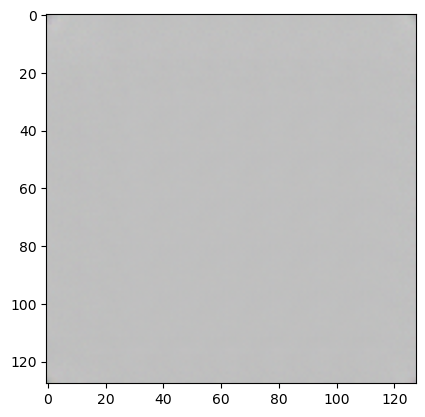

In [ ]:
plt.imshow(recons[0])

In [ ]:
loss = np.array(loss)
y = np.arange(30)
y = y+1
y

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

/var/folders/4h/dwdjsw5n1ln0ngs7nflp8q2h0000gn/T/ipykernel_40961/1154954189.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(y, loss, '-ok', color='black')


Text(0, 0.5, 'loss')

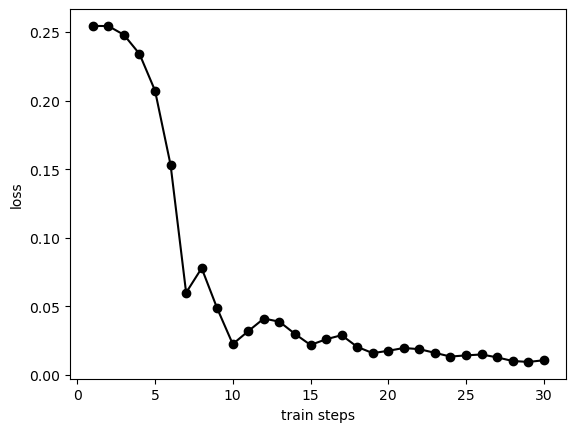

In [ ]:
plt.plot(y, loss, '-ok', color='black')
plt.xlabel("train steps")
plt.ylabel("loss")

In [ ]:
x = np.arange(10)
x = x+1

/var/folders/4h/dwdjsw5n1ln0ngs7nflp8q2h0000gn/T/ipykernel_40961/3110805735.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, average_loss, '-ok', color='black')


Text(0, 0.5, 'training loss')

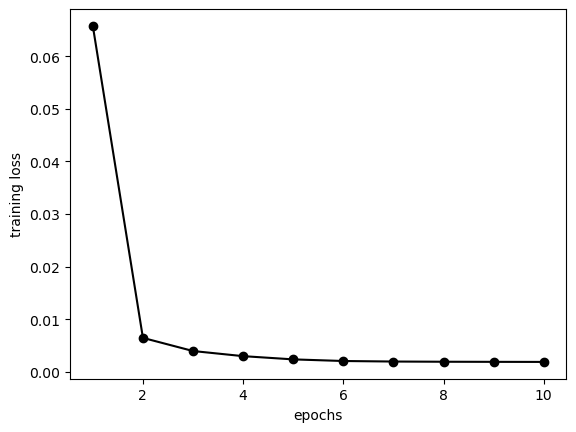

In [ ]:
  plt.plot(x, average_loss, '-ok', color='black')
  plt.xlabel("epochs")
  plt.ylabel("training loss")